# Training with CFG representation

In [1]:
!python -m pip list

Package                Version  
---------------------- ---------
absl-py                0.12.0   
anyio                  2.2.0    
argon2-cffi            20.1.0   
astunparse             1.6.3    
async-generator        1.10     
attrs                  20.3.0   
Babel                  2.9.0    
backcall               0.2.0    
bleach                 3.3.0    
cachetools             4.2.1    
certifi                2020.12.5
cffi                   1.14.5   
chardet                4.0.0    
cycler                 0.10.0   
dask                   2021.3.0 
decorator              4.4.2    
defusedxml             0.7.1    
entrypoints            0.3      
flatbuffers            1.12     
gast                   0.3.3    
google-auth            1.27.1   
google-auth-oauthlib   0.4.3    
google-pasta           0.2.0    
grpcio                 1.32.0   
h5py                   2.10.0   
idna                   2.10     
ipykernel              5.5.0    
ipython                7.21.0   
ipython-ge

In [2]:
!nvidia-smi

Fri Mar 19 19:15:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    On   | 00000000:01:00.0 Off |                  N/A |
|  0%   45C    P0    37W / 151W |     82MiB /  8118MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import gc
import os
import sys
import yaml
import glob
import numpy as np
import pickle
import tensorflow as tf
import random
import tqdm
import seaborn as sn
import numpy as np

from collections import defaultdict

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from spektral.datasets import delaunay
from spektral.layers import *
from spektral.utils.convolution import localpooling_filter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tqdm.contrib.concurrent import process_map, thread_map

from utils import yaml_load, get_section

%matplotlib inline

In [4]:
# Read data
input_data = './data/cfgs_20000samples_150x150.npz'

# Lets read ll 
with np.load(input_data, allow_pickle=True) as all_data:
    A = all_data['graphs']      # Graphs matrices
    X = all_data['features']    # Features matrices
    y = all_data['speedups']     # Speedup matrices (targets)

print(f'Data loaded from {input_data}.')

# Generate classed based on speedup
y_c = np.zeros(shape=(y.shape[0],5))

for i in range(0, y.shape[0]):
    if y[i] <= 0.996:
        y_c[i,0]=1
    elif y[i] > 0.996 and y[i] < 1.0:
        y_c[i,1]=1
    elif (y[i] >= 1.0 and y[i] < 1.15):
        y_c[i,2]=1
    elif (y[i] > 1.15):
        y_c[i,3]= 1
    y_c[i,4] = y[i]
y = y_c

print('Speedup classes generated.')

# Remove 0 columns in nodes features
#idx = np.argwhere(np.all(X[..., :] == 0, axis=(0,1,2)))
#X = np.delete(X, idx, axis=3)

print(f"""Datas:
A shape (graphs): {A.shape}
X shape (features): {X.shape}
y shape (targets): {y.shape} 
""")

Data loaded from ./data/cfgs_20000samples_150x150.npz.
Speedup classes generated.
Datas:
A shape (graphs): (20000, 2, 150, 150)
X shape (features): (20000, 2, 150, 67)
y shape (targets): (20000, 5) 



In [5]:
# Defining some parameters for training
N = X.shape[-2]                 # Number of nodes in the graphs
F = X.shape[-1]                 # Original feature dimensionality
n_classes = y_c.shape[-1]-1     # Number of classes
epochs = 500                    # Number of training epochs
batch_size = 16                 # Batch size
learning_rate = 1e-2            # Learning rate

# Preprocess all graphs with Spektral package
A[:,0,:,:] = GraphConv.preprocess(A[:,0,:,:]).astype('f4')
A[:,1,:,:] = GraphConv.preprocess(A[:,1,:,:]).astype('f4')

# Split Train and test sets
A_train, A_test, x_train, x_test, y_train, y_test = train_test_split(A, X, y, test_size=0.1)

# Cleanup
del A, X, y, y_c
gc.collect()

66

In [6]:
# Utils
data_dir = f'./model_data/GNN_cfg_trained_epochs{epochs}_batch{batch_size}'
os.makedirs(data_dir, exist_ok=True)

info_file = os.path.join(data_dir, 'info.yaml')
info = {
    'num_nodes': N,
    'feature_dim': F,
    'n_classes': n_classes,
    'epochs': epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate
}

with open(info_file, 'wt') as f:
    yaml.dump(info, f)

In [7]:
# Model definition
conv   = GraphConv(45,activation='relu',use_bias=False)
mincut = MinCutPool(N // 2)
conv2  = GraphConv(55,activation='relu',use_bias=False)
pool   = GlobalAttnSumPool()

# First Graph Layers
X1_in = Input(shape=(N, F))
A1_in = Input((N, N))
gc2_1 = conv([X1_in, A1_in])
gc2_1, A1 = mincut([gc2_1,A1_in])
gc2_1 = conv2([gc2_1, A1])
pool_1 =  pool(gc2_1)
d1 = Dense(200,activation='relu')(pool_1)

# Second Graph Layers
X2_in = Input(shape=(N, F))
A2_in = Input((N, N))
gc2_2 = conv([X2_in, A2_in]) # Notice that both graphs shares layers (shared weights)
gc2_2, A2 = mincut([gc2_2,A2_in])
gc2_2 = conv2([gc2_2, A2])
pool_2 = pool(gc2_2)
d2 = Dense(200,activation='relu')(pool_2)

# Dense final layers
merged = Concatenate()([d1, d2])

merged1 = Dense(800,activation='relu')(merged)
merged2 = Dense(32,activation='relu')(merged1)

classe = Dense(n_classes, name="class",activation="softmax")(merged2)
speedup = Dense(1, name="speddup")(merged2)

# Build model
model = Model(inputs=[X1_in, A1_in,X2_in, A2_in], outputs=[classe,speedup])
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=['categorical_crossentropy', 'mse'],loss_weights=[1, 0.00005], weighted_metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 67)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 67)]    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 150, 150)]   0                                            
______________________________________________________________________________________________

Epoch 1/500
1069/1069 [==============================] - 8s 6ms/step - loss: 5.2447 - class_loss: 1.2619 - speddup_loss: 69086.5787 - class_acc: 0.4599 - speddup_acc: 1.6686e-05 - val_loss: 4.4114 - val_class_loss: 1.1533 - val_speddup_loss: 57028.3359 - val_class_acc: 0.4544 - val_speddup_acc: 0.0000e+00
Epoch 2/500
1069/1069 [==============================] - 6s 6ms/step - loss: 3.3937 - class_loss: 1.1081 - speddup_loss: 37727.2270 - class_acc: 0.4817 - speddup_acc: 2.9367e-05 - val_loss: 4.3744 - val_class_loss: 1.1191 - val_speddup_loss: 57009.8398 - val_class_acc: 0.5022 - val_speddup_acc: 0.0000e+00
Epoch 3/500
1069/1069 [==============================] - 6s 6ms/step - loss: 3.2570 - class_loss: 1.0906 - speddup_loss: 35393.7555 - class_acc: 0.5053 - speddup_acc: 1.4695e-04 - val_loss: 4.3601 - val_class_loss: 1.1016 - val_speddup_loss: 56979.9414 - val_class_acc: 0.4867 - val_speddup_acc: 0.0000e+00
Epoch 4/500
1069/1069 [==============================] - 6s 6ms/step - loss: 3.

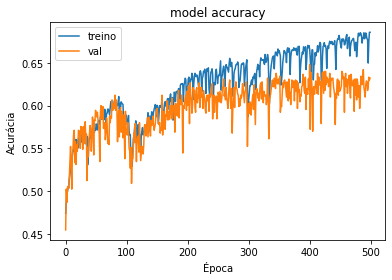

In [8]:
# Train model
history = model.fit([x_train[:,0,:,:], A_train[:,0,:,:], x_train[:,1,:,:], A_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=batch_size, validation_split=0.05, epochs=epochs)

plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

In [9]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=batch_size)
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

Evaluating model.
125/125 [==============================] - 1s 3ms/step - loss: 1.3775 - class_loss: 0.9532 - speddup_loss: 41.8041 - class_acc: 0.6210 - speddup_acc: 0.0000e+00
Done. Test loss: 1.3775. Test acc: 0.95


Confusion matrix:
[[747  29 235 175]
 [  1   3   7   0]
 [148  43 307  46]
 [ 19   0  55 185]]
Figure saved to ./model_data/GNN_cfg_trained_epochs500_batch16/confusion_matrix.pdf


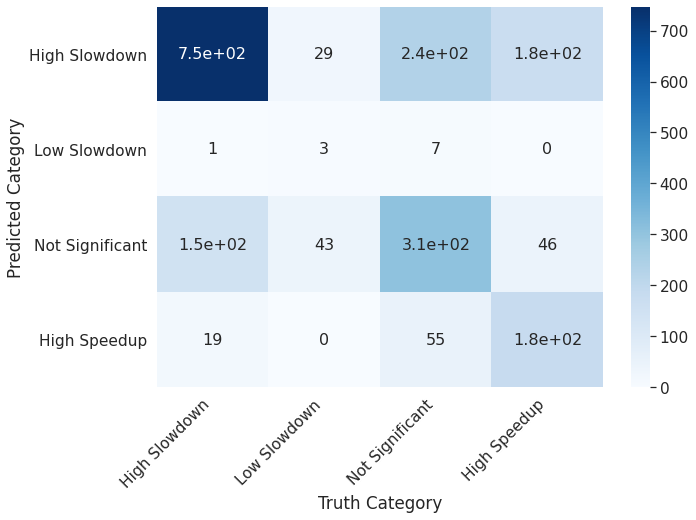

In [10]:
print("Confusion matrix:")
pred_vals = model.predict([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

Optionally, we save the trained network for further reuse (model configuration and weights)

In [11]:
# Saving model and weights
output_model_file = os.path.join(data_dir, 'model.yaml')
with open(output_model_file, 'wt') as f:
    yaml.dump(model.to_yaml(), f)
print(f'Model saved to {output_model_file}')

output_weights_file = os.path.join(data_dir, 'weights.h5')
model.save_weights(output_weights_file)
print(f"Weights saved to file {output_weights_file}")

Model saved to ./model_data/GNN_cfg_trained_epochs500_batch16/model.yaml
Weights saved to file ./model_data/GNN_cfg_trained_epochs500_batch16/weights.h5
